In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from fastai.vision.all import *
import torch.nn as nn
import torch.nn.functional as F

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])
trainset = tv.datasets.FashionMNIST(root='./data',  train=True,download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False, num_workers=4)
testset = tv.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

In [4]:
def visualize_reconstruction(model, data_loader, num_images=5):
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            inputs = data[0].to(device)
            outputs = model(inputs)
            break  # Only take the first batch

    inputs = inputs[:num_images]
    outputs = outputs[:num_images]

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
    for i in range(num_images):
        axes[0, i].imshow(inputs[i].squeeze().cpu().numpy(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        axes[1, i].imshow(outputs[i].squeeze().cpu().numpy(), cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')

    plt.show()

In [5]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def deconv(ni, nf, ks=3, act=True):
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
              nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

model1 = nn.Sequential(   #28x28
    nn.ZeroPad2d(2),  #32x32
    conv(1,2),        #16x16
    conv(2,4),        #8x8
    conv(4,8),        #4x4
    deconv(8,4),      #8x8
    deconv(4,2),      #16x16
    deconv(2,1, act=False), #32x32
    nn.ZeroPad2d(-2), #28x28
    nn.Sigmoid()
).to(device)

In [8]:
# Model and other definitions
num_epochs = 1
distance = nn.MSELoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.01)

In [10]:
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss,count = 0.,0
        for xb,_ in valid_dl:
            pred = model(xb.to(device))
            n = len(xb.to(device))
            count += n
            tot_loss += loss_func(pred,xb.to(device)).item()*n
    print(epoch, f'{tot_loss/count:.3f}')

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,_ in train_dl:
            xb = xb.to(device)
            loss = loss_func(model(xb), xb)

            loss.backward()
            opt.step()
            opt.zero_grad()

        eval(model, loss_func, valid_dl, epoch)

In [10]:
fit(4, model1, distance, optimizer, dataloader, testloader)

0 0.732
1 0.631
2 0.617
3 0.609


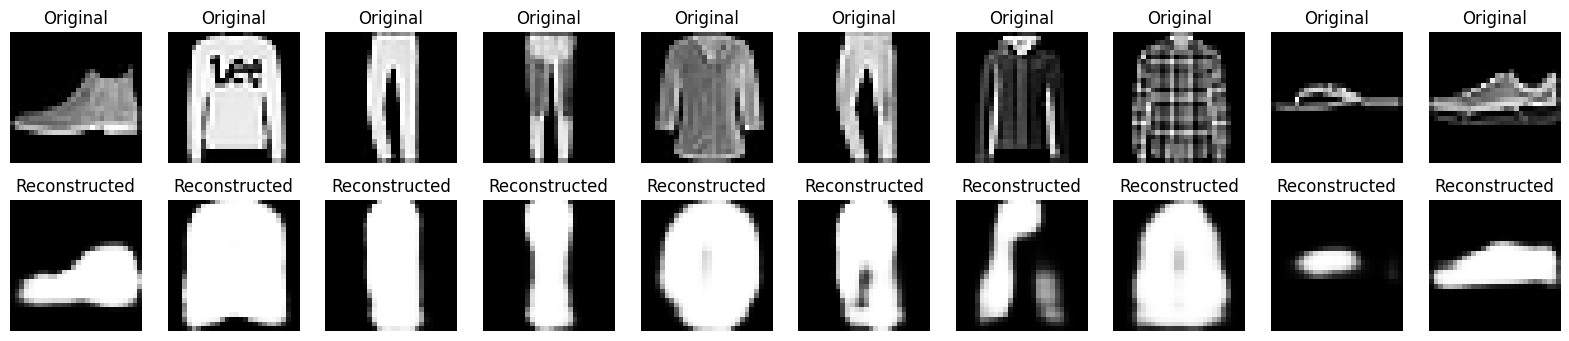

In [11]:
visualize_reconstruction(model1, testloader, num_images=10)

More complex model

In [12]:
class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(           #28
            nn.Conv2d(1, 16, kernel_size=3, padding=1),   #28
            nn.ReLU(True),
            nn.MaxPool2d(2,2),                 #14
            nn.Conv2d(16, 8, kernel_size=3, padding=1),    #14
            nn.ReLU(True),
            nn.MaxPool2d(2,2),                  #7
            nn.Conv2d(8, 3, kernel_size=3, padding=1),     #7
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(             
            nn.UpsamplingNearest2d(scale_factor=2),  #14
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.UpsamplingNearest2d(scale_factor=2),   #28
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
            )


    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
model3 = Autoencoder().to(device)  # Move model to GPU
distance = nn.MSELoss()
optimizerAdam = torch.optim.Adam(model3.parameters(), weight_decay=1e-5)

In [14]:
fit(4, model3, distance, optimizerAdam, dataloader, testloader)

0 0.553
1 0.546
2 0.543
3 0.542


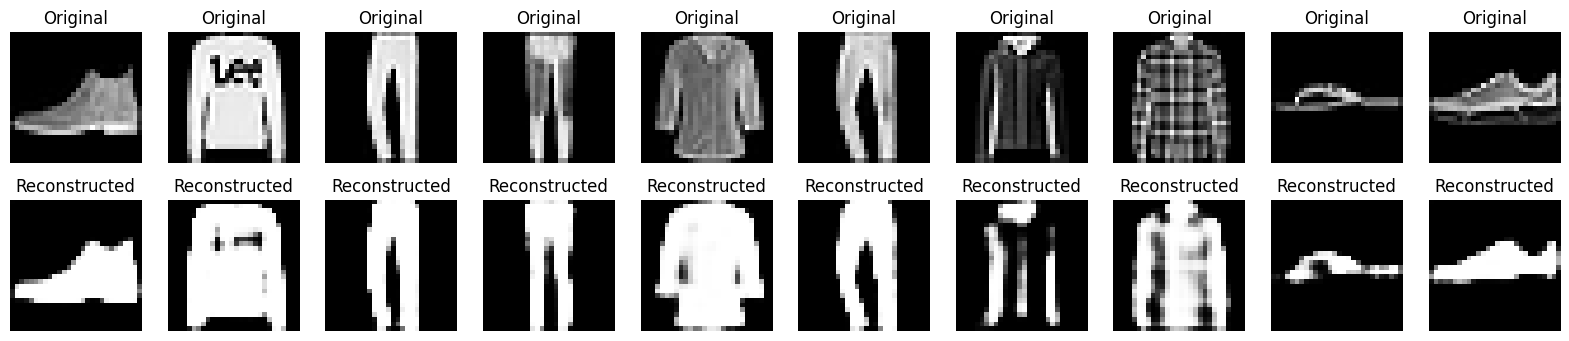

In [15]:
visualize_reconstruction(model3, testloader, num_images=10)

In [7]:
model4 = nn.Sequential(   #28x28
    nn.ZeroPad2d(2),  #32x32
    conv(1,12),        #16x16
    conv(12,24),        #8x8
    # conv(48,96),        #4x4
    # deconv(96,48),      #8x8
    deconv(24,12),      #16x16
    deconv(12,1, act=False), #32x32
    nn.ZeroPad2d(-2), #28x28
    nn.Sigmoid()
).to(device)

In [19]:
distance = nn.MSELoss()
optimizerAdam = torch.optim.Adam(model4.parameters(), weight_decay=1e-8, lr=0.001)

In [20]:
fit(12, model4, distance, optimizerAdam, dataloader, testloader)

0 0.577
1 0.575
2 0.575
3 0.575
4 0.574
5 0.574
6 0.573
7 0.573
8 0.573
9 0.573
10 0.572
11 0.571


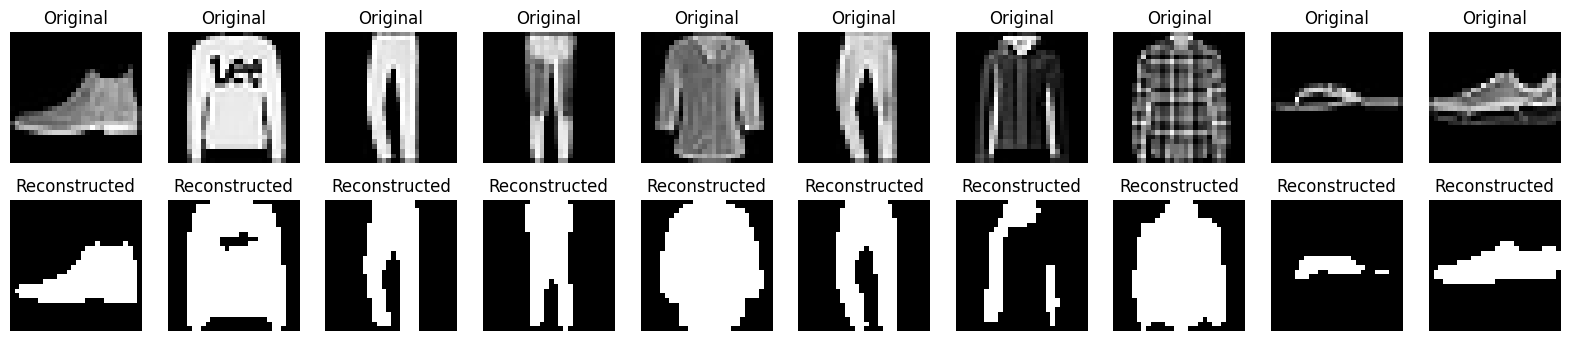

In [21]:
visualize_reconstruction(model4, testloader, num_images=10)